# Forensic Intelligence Applications
In this section we will explore the use of __similar source, score-based, non-anchored LRs__ for forensic intelligence applications. Score-based LRs can be a valuable tool for relating forensic traces to each other in a manner that pertains to:

* The relative __rarity__ of a relationship between two traces
* The different __senses__ of similarity and thier expression in terms of multivariable features

We will explore the use of __likelihood ratios__ as a method for exploring the __connectivity__ between forensic traces. As well as the interactive process of asking different kinds of forensic questions and interpretting the results.

### How to work with the Jupyter notebook interface
Each cell contains some code that is executed when you select any cell and:
<br />
<center>click on the __execute__ icon<br />
OR<br />
presses <code>CRTL + ENTER</code><br />
</center>
<br />
In between these code cells are text cells that give explanations about the input and output of these cells as well as information about the operations being performed. In this workshop segment we will work our way down this iPython3 notebook. All the code cells can be edited to change the parameters of our example. We will pause to discuss the output generated at various stages of this process.


### Accessing this notebook
After this workshop is over, you will be able to download this notebook any time at:
__http://www.score_LR_demo.pendingassimilation.com__

### Lets get started
Execute the following code cell in order to import al of the Python3 libraries that will be required to run our example. <br/>
This code will also change the colour scheme of all code cells so that you can more easily tell the difference between <br/> __instruction cells__ (black text white background) and __code cells__ syntax coloured text on a black background.

In [37]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
## importing nice mathy things
import numpy as np # numericla operators
import matplotlib.pyplot as plt # plotting operators
import matplotlib
from numpy import ndarray 
import random # for random data generation
from matplotlib.mlab import PCA as mlabPCA # pca required for plotting higher dimensional data
import matplotlib.mlab as mlab
from scipy.stats import norm
import networkx as nx # for generating and plotting graphs
from scipy.spatial.distance import pdist, cdist, squareform # pairwise distance operators
from scipy import sparse as sp
css_styling() # defines the style and colour scheme for the markdown and code cells.


### Define some characteristics of the dataset for our example
We will generate a dataset meant to emulate the kinds of intel availabel in pan-european drug seizure analysis. <br>
The variables bellow will define our dataset for this example, including the number of seizure __batches__, the number of __samples__ per seizure batch and the relative variability observed in the samples. Some noise parameters are introduced as well and we assume a particular number of marker compounds are measured between seizures.<br>

__Remember! This is only example data to illustrate the technology you can come back here and change the nature of the exmaple data any time__

In [38]:
NUMBER_OF_CLASSES = 10 
# number of different classes 
SAMPLES_PER_CLASS = 100 
# we assume balanced classes
NOISINESS_INTRA_CLASS = 0.25 
#expresses the spread of the classes (between 0.0 and 1.0 gives workable data)
NOISINESS_INTER_CLASS = 4.5 
# expresses the spaces in between the clases (between 5 and 10 times the value of NOISINESS_INTRA_CLASS is nice)
DIMENSIONALITY = 10 
# how many features are measured for this multivariate data
FAKE_DIMENSIONS = 2 # these features are drawn from a different (non class specific distribution) so as to have no actual class descriminating power.

if NUMBER_OF_CLASSES * SAMPLES_PER_CLASS > 10000:
    print('Too many samples requested, please limit simulated data to 10000 samples to avoid slowing down the server kernel... Using Default values')
    print(NUMBER_OF_CLASSES)

### Generate a sample data set
The following code cell will generate a new simulated data set according to the parameters defined in the previous code cell

In [39]:
##simulate interesting multiclass data 
myData = np.empty((0,DIMENSIONALITY), int)
nonInformativeFeats = np.array(random.sample(range(DIMENSIONALITY), FAKE_DIMENSIONS))

labels =  np.repeat(range(NUMBER_OF_CLASSES), SAMPLES_PER_CLASS) # integer class labels
#print labels

for x in range(0, NUMBER_OF_CLASSES):
    A = np.random.rand(DIMENSIONALITY,DIMENSIONALITY)
    cov = np.dot(A,A.transpose())*NOISINESS_INTRA_CLASS # ensure a positive semi-definite covariance matrix, but random relation between variables
    mean = np.random.uniform(-NOISINESS_INTER_CLASS, NOISINESS_INTER_CLASS, DIMENSIONALITY) # random n-dimensional mean in a space we can plot easily
    #print('random mutlivariate distribution mean for today is', mean)
    #print('random positive semi-define matrix for today is', cov)

    x = np.random.multivariate_normal(mean,cov,SAMPLES_PER_CLASS)
    myData = np.append(myData,  np.array(x), axis=0)
    # exit here and concatenate

x = np.random.multivariate_normal(np.zeros(FAKE_DIMENSIONS),mlab.identity(FAKE_DIMENSIONS),SAMPLES_PER_CLASS*NUMBER_OF_CLASSES)
myData[:, nonInformativeFeats.astype(int)] = x
# substitute the noninformative dimensions with smaples drawn from the sampe boring distribution
    
#print myData    

### Examine the generated data
The following code cell will display a 2-dimensional projection of your simulated illicit drugs seizure data set.<br>
The colours indicate similar source seizures. Remember, this is a projection of the higher-dimensional data for plotting purposes only.

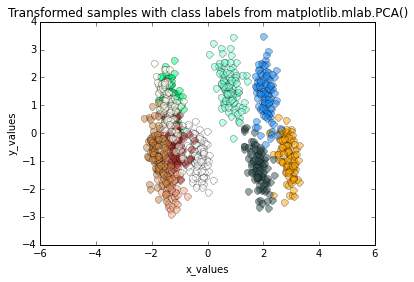

In [40]:
## plotting our dataset to see if it is what we expect
names = matplotlib.colors.cnames #colours for plotting
names_temp = names

col_means = myData.mean(axis=0,keepdims=True)
myData = myData - col_means # mean center the data before PCA

col_stds = myData.std(axis=0,keepdims=True)
myData = myData / col_stds # unit variance scaling 

results = mlabPCA(myData)# PCA results into and ND array scores, loadings
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal');
for i in range(NUMBER_OF_CLASSES):
    plt.plot(results.Y[labels==i,0],results.Y[labels==i,1], 'o', markersize=7, color=names_temp.popitem()[1], alpha=0.5)
# plot the classes after PCA just for rough idea of their overlap.

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')
    
plt.show()

###Defining a similarity model to generate score-based likelihood ratios
Here we must define three parameters that will affect the shape of our graph.<br>
* The distance metric will convert the high dimensional data into a set of __univariate pair-wise scores__ between samples.
* The __distribution__ that will be used to model the scores in one dimension must be chosen here.
* The __holdout size__ is a set of sample from our generated data set that will be removed before modelling the distributions.

The holdout samples will be used later to draw graphs. We can verify if useful intel is being provided based on the original seizure identities of the holdout samples. The holdout set is a random sample from the full data generated.

In [41]:
DISTANCE_METRIC = 'canberra'
# this can be any of: euclidean, minkowski, cityblock, seuclidean, sqeuclidean, cosine, correlation
# hamming, jaccard, chebyshev, canberra, braycurtis, mahalanobis, yule
DISTRIBUTION = 'normal'
HOLDOUT_SIZE = 0.01

In [42]:
# optional feature selection/masking for different questions
sz = myData.shape
RELEVANT_FEATURES = range(0,sz[1])

#### Later feature selcection occurs here ####
#RELEVANT_FEATURES = [2,5,7] ####
#### Selected features specifically relevant to precursor chemical composition
#####################################
myData = myData[:,RELEVANT_FEATURES]

### Dividing the data
The following code cell executes the data division as defined above and reports on the size of your reference collection, holdout set, and the dimensionality of the data. Additionally a  graphical sample of the data is displayed with variable magnitudes mapped to a cold->hot colour scale.

((990, 10), 'is the size of the data used to model same-source and different-source distributions')
((10, 10), 'are the points we will evaluate to see LRs achieved')


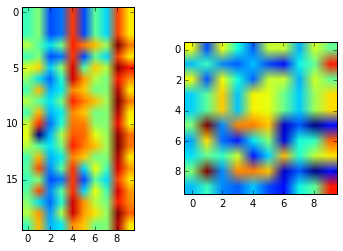

In [43]:
# divide the dataset
idx = np.random.choice(np.arange(NUMBER_OF_CLASSES*SAMPLES_PER_CLASS), int(NUMBER_OF_CLASSES*SAMPLES_PER_CLASS*HOLDOUT_SIZE), replace=False)
#10% holdout set removed to demonstrate the LR values of new samples!

test_samples = myData[idx,:]
test_labels = labels[idx]

train_samples = np.delete(myData, idx, 0)
train_labels = np.delete(labels, idx)

print(train_samples.shape, 'is the size of the data used to model same-source and different-source distributions')
print(test_samples.shape, 'are the points we will evaluate to see LRs achieved')

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(train_samples[np.random.randint(DIMENSIONALITY,size=DIMENSIONALITY*2),:])
axes[1].imshow(test_samples[np.random.randint(test_samples.shape[0],size=test_samples.shape[0]),:])
plt.show()

##Modeling the general sense of similarity
The following code cell does a lot of the work necessary to get from __multivariate data__ to __univariate score-based likelihood ratios__
####If you attended the lecture from Jacob about score-based LRs then this should be very familiar!
* First, pair wise comparisons are where source identity is known (because the data was generated with a ground truth)
* The comparisons are accumalated into groups based on the source identity __same__ or __different__ batch
* The acumalated score distributions are modeled using a __probability density function__
* The parameters of those distributions and a graphical representation is displayed



('same source comparisons made: ', 48514)
('diff source comparisons made: ', 882082)


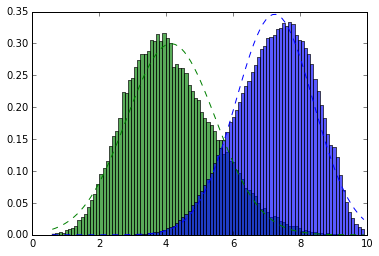

In [44]:
#Pairwise distance calculations are going in here
same_dists = np.empty((0,1))
diff_dists = np.empty((0,1))

for labInstance in np.unique(train_labels):
    dists = pdist(train_samples[train_labels==labInstance,:],DISTANCE_METRIC)
    # this is already the condensed-form (lower triangle) with no duplicate comparisons.
    same_dists = np.append(same_dists, np.array(dists))
    del dists
        
    dists = cdist(train_samples[train_labels==labInstance,:], train_samples[train_labels!=labInstance,:], DISTANCE_METRIC)
    #print dists.shape
    train_samples[train_labels!=labInstance,:]
    diff_dists = np.append(diff_dists, np.array(dists).flatten())
#print same_dists.shape
#print diff_dists.shape

minval = min(np.min(diff_dists),np.min(same_dists))
maxval = max(np.max(diff_dists),np.max(same_dists))

# plot the histograms to see difference in distributions
# Same source data 
mu_s, std_s = norm.fit(same_dists) # fit the intensities wth a normal
plt.hist(same_dists, np.arange(minval, maxval, abs(minval-maxval)/100), normed=1, facecolor='green', alpha=0.65)
y_same = mlab.normpdf(np.arange(minval, maxval, abs(minval-maxval)/100), mu_s, std_s) # estimate the pdf over the plot range
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_same, 'g--', linewidth=1)

# Different source data
mu_d, std_d = norm.fit(diff_dists) # fit the intensities wth a normal
plt.hist(diff_dists, np.arange(minval, maxval, abs(minval-maxval)/100), normed=1, facecolor='blue', alpha=0.65)
y_diff = mlab.normpdf(np.arange(minval, maxval, abs(minval-maxval)/100), mu_d, std_d) # estimate the pdf over the plot range
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_diff, 'b--', linewidth=1)

print('same source comparisons made: ', same_dists.shape[0])
print('diff source comparisons made: ', diff_dists.shape[0])

###Relating a score to a likelihood ratio
The following code cell compares the __new seizures__ (remember we seperated them into the holdout set early on) against the distributions that we modelled from our __forensic reference collection__ to determine how __rare__ a particular score between two illicit drug profiles is in the context of our cummalitive knowlegde of the market as define by our seizures collection.
* The distribution relating to pair-wise similarities between __same source__ samples is plotted in green
* The distribution relating to pair-wise similarities between __different source__ samples is plotted in blue
* The new __recovered__ samples are compared to one another and plotted as dots along the top of the figure





(' mu same: ', 4.1479823703266119, ' std same: ', 1.3311233218261207)
(' mu diff: ', 7.2382125077052653, ' std diff: ', 1.1536972086756412)


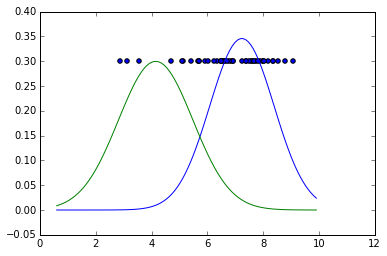

In [45]:
print(' mu same: ', mu_s, ' std same: ', std_s)
print(' mu diff: ', mu_d, ' std diff: ', std_d)

newDists = squareform(pdist((test_samples),DISTANCE_METRIC)) # new samples (unknown group memebership)
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_diff, 'b-', linewidth=1)
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_same, 'g-', linewidth=1)

l=plt.scatter(squareform(newDists), np.ones(squareform(newDists).shape[0], dtype=np.int)*max(y_same))
# plot the new distances compared to the distributions

lr_holder = [];

for element in squareform(newDists):
    value = mlab.normpdf(element, mu_s, std_s)/mlab.normpdf(element, mu_d, std_d)
    lr_holder.append(value)
    #print value
#lr_holder = np.true_divide(lr_holder,1) #inversion becasue now it will be used as a spring for network plotting
newDists[newDists==0] = 0.000001 # avoid divide by zero
newDists = np.true_divide(newDists,newDists.max()) 


### Set thresholds for edges in your undirected graph
In the following code cell we must set the thresholds for drawing edges between seizures in a __graph__ based on thier __similarity__ and the __likelihood ratio__ of observing that similarity given they originate from the same source. The output figure at the bottom of the previous code cell can help you decide on a realistic threshold. <br>

__The same points will be used for the graph using similarity scores as the graph using likelihood ratios so that they can be compared__

In [46]:
# SET  A THRESHOLD FOR EDGES:
EDGE_THRESHOLD_DISTANCE = 0.75
EDGE_THRESHOLD_LR = 1.0

### Generate a graph using the similarity between samples as a linkage function
The following code block examines the pairwise similarity between __hold out__ samples and then compares that similarity to the threshold you defined.
The weight of the edges is determined by the magnitude of the similarity score (normalized to a range of 0.0-1.0).
* Closer nodes are more similar to one another. 
* Edges not meeting the threshold criteria are removed.
* Any unconnected nodes are removed.


('node indeces:', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
(' seizure ids:', [4, 8, 8, 8, 2, 6, 7, 0, 7, 3])


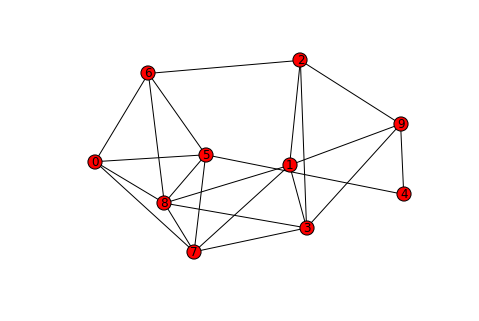

In [47]:
# Plot just the distance based graph
G = nx.Graph(); # empty graph
I,J,V = sp.find(newDists) # index pairs associated with distance
G.add_weighted_edges_from(np.column_stack((I,J,V))) # distance as edge weight

#pos=nx.spectral_layout(G) # automate layout in 2-d space
#nx.draw(G,  pos, node_size=200, edge_color='k', with_labels=True, linewidths=1,prog='neato') # draw
#print G.number_of_edges()

for e in G.edges_iter(data=True):
    if G[e[0]][e[1]]['weight'] > EDGE_THRESHOLD_DISTANCE:
        G.remove_edge(e[0],e[1]) # remove edges that indicate weak linkage
#print G.number_of_edges()

pos=nx.spring_layout(G) # automate layout in 2-d space
G = nx.convert_node_labels_to_integers(G)
nx.draw(G,  pos, node_size=200, edge_color='k', with_labels=True, linewidths=1,prog='neato') # draw
print('node indeces:', G.nodes())
print(' seizure ids:', list(test_labels))

### Generate a graph using the likelihood ratio as a linkage function
The following code block examines the likelihood ratio of observing a particular score between pairs of the __hold out__ samples. The scores are then compared against the similarities modeled using our forensic reference samples to determine how rare the observation of such a score is. The weight of the edges is determined by the magnitude of the __likelihood ratio of observing the score given the following competing hypotheses:__
* Hp: The samples originate from a common source
* Hd: The samples originate from a different and arbitrary source

As with the graph based on similarity scores alone:
* Edges not meeting the threshold criteria are removed.
* Any unconnected nodes are removed.



('node indeces:', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
(' seizure ids:', [4, 8, 8, 8, 2, 6, 7, 0, 7, 3])


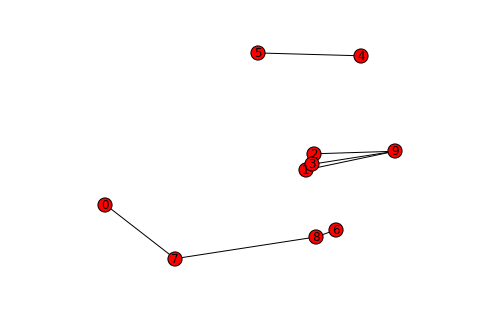

In [48]:
# plot the likelihood based graph
#print lr_holder
G2 = nx.Graph(); # empty graph
I,J,V = sp.find(squareform(lr_holder)) # index pairs associated with distance
G2.add_weighted_edges_from(np.column_stack((I,J,V))) # LR value as edge weight

for f in G2.edges_iter(data=True):
    if G2[f[0]][f[1]]['weight'] < EDGE_THRESHOLD_LR:
        G2.remove_edge(f[0],f[1]) # remove edges that indicate weak linkage
#print G.number_of_edges()

pos=nx.spring_layout(G2) # automate layout in 2-d space
G2 = nx.convert_node_labels_to_integers(G2)
nx.draw(G2,  pos, node_size=200, edge_color='k', with_labels=True, linewidths=1,prog='neato')
print('node indeces:', G2.nodes())
print(' seizure ids:', list(test_labels))

<center>
### You can now go back to any of the code cells and experiment with changing parameters! After each change, scroll back down to the graphs to see the results.

### Each time you make a change click on "Cell > Run All" in the menu


### Feature selection for hypthoses investigation

Particular variables may be __known__ to relate to characteristics that are of particular investigative interest. For example some chemical characteristics quantified in illicit drug profiling may relate to residual composition of specific precursor compounds.

We can articulate a new source identitiy hypothesis in terms of the features we allow to be used in our model. For example the variables selected thus far are defined in an earlier cell.
<br/>

* scroll back up to cell 9, which should contain the following text
<code>
\#### Later feature selcection occurs here ####
\# RELEVANT_FEATURES = [2,5,7] ####
\#### Selected features specifically relevant to precursor chemical composition
\#####################################
</code>
<br>
* Now make the following change :
__remove this \# symbol -----> <code>\# RELEVANT_FEATURES = [2,5,7] ####</code>




### Intel from graph analytics
Investigation of the characteristics of the graph using __similar source, score-based, non-anchored LRs__ as a linkage function can yield interesting discoveries pertaining to particular nodes. In this case nodes may represent pieces of evidence, or case dossiers where multiple types of information are considered as features in a multivariate model.

<br/>
__In our example the nodes represent drug seizures__ and their features are impurity compounds resulting of chemical fingerprinting.
<br/>
Some interesting characteristics of the graph might be:

* The most connected element (perhaps indicating a high similarity to the largest number of other seizures)
* The general degree of connectivity of the graph (perhaps an indication of the interconnectivity of seizures in the market)
* biapartitie projectiongs of the graph (indicating the number of elements/element groupings likely to be independent of one another)
* Connectivity between pairs of nodes in the graph based on different edge thresholds now that edges are directly related to likelihoods based on our forensic reference collection more or less likely connections have a very intuitive meaning in the graph space.
<br>
There are __many__ more graph theory algorithms that can be deplyed to analyze a large group of forensic traces see:
<code>
https://networkx.github.io/documentation/latest/reference/algorithms.html
</code>




## Thank you for your attendance and your attention!